### https://unexpectedcoder.github.io/computer-sim-labs/lab-1-ca-forest.html

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from IPython.display import clear_output
from enum import Enum
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
from typing import Optional, Tuple, List
import cProfile

In [52]:
# "Seed" for the pseudorandom number generator
seed = 1097
# Dimensions of the cellular field
w, h = 200, 200
# Fraction of cells with trees
eta = 0.8
# Number of initially burning trees
f = 1
# Probability of a new tree growing
p_g = 0.02
# Probability of random ignition of a tree
p_f = 2e-5
# Model time (number of automaton updates)
sim_time = 500

In [53]:
rs = np.random.RandomState(seed=seed)

colors = ["#49423D", "orange", "green"]
cmap_forest = ListedColormap(colors)

In [54]:
Matrix = np.ndarray
Array = np.ndarray
Axes = plt.Axes
Figure = plt.Figure

In [64]:
class NeighborhoodType(Enum):
    CROSS = 'x'
    NEUMAN = '+'
    
class CellState(Enum):
    EMPTY = 0
    FIRING = 1
    TREE = 2
    
class CellColor(Enum):
    EMPTY = colors[0]
    FIRING = colors[1]
    TREE = colors[2]

In [56]:
def plot_grid(ca: Matrix, ax: Optional[Axes]=None, **kw) -> Tuple[Figure, Axes]:
    """
    Draws a colored grid from a matrix.
    
    ca - input matrix with numbers
    ax - existing plot axes (if None, creates new)
    **kw - optional parameters like title="My plot"
    
    Returns: figure and axes objects
    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.matshow(ca, cmap=cmap_forest)
    title = kw.get("title", "")
    ax.set(
        xlabel="Length",
        ylabel="Width",
        title=title,
        aspect="equal"
    )

    return fig, ax

In [57]:
def create_ca(h: int, w: int) -> Matrix:
    """
    Creates empty matrix of size h x w.
    """
    return np.zeros((h, w))

def grow_trees(ca: Matrix, eta: float) -> Matrix:
    """
    Gets zeros like matrix.
    Changes matrix depending on density eta.
    Returns: result matrix.
    """
    random_matrix = rs.random(ca.shape) + 1e-10
    return np.where(random_matrix <= eta, CellState.TREE.value, ca)

def firing_trees(ca: Matrix, f: int) -> Matrix:
    """
    Returns: matrix with random f amount of CellState.FIRING values.
    """
    h, w = ca.shape
    firing_xs = rs.randint(low=0, high=w, size=f)
    firing_ys = rs.randint(low=0, high=h, size=f)
    result = ca.copy()
    result[firing_ys, firing_xs] = CellState.FIRING.value
    return result

def init_state(ca: Matrix, eta: float, f: int) -> Matrix:
    """
    Returns: initialized matrix
    """
    trees = grow_trees(ca, eta)
    firing = firing_trees(trees, f)
    return firing

In [58]:
def get_neuman_neighborhood(cell: Tuple[int, int],
                           ca_shape: Tuple[int, int]) -> Array:
    """
    Returns: indexes of surrounding cells in case of "+"-neighborhood.
    """
    directions = np.array([(-1, 0), (1, 0), (0, -1), (0, 1)])
    directions += cell
    neighbors = [x for x in directions if x[0] < ca_shape[0] and x[1] < ca_shape[1]]
    return np.array(neighbors)

def get_cross_neighborhood(cell: Tuple[int, int],
                            ca_shape: Tuple[int, int]) -> Array:
    """
    Returns: indexes of surrounding cells in case of "x"-neighborhood.
    """
    directions = np.array([(-1, 0), (1, 0), (0, -1), (0, 1), 
                           (-1, -1), (1, 1), (1, -1), (-1, 1)])
    directions += cell
    neighbors = [x for x in directions if x[0] < ca_shape[0] and x[1] < ca_shape[1]]
    return np.array(neighbors)
    

In [59]:
def update_cell(ca: np.ndarray,
                new_ca: np.ndarray,
                cell: Tuple[int, int],
                neighbor_indexes: Array) -> None:
    """
    Updates the cell state according to evolution rules.
    """
    useful =ca[neighbor_indexes[:, 0], neighbor_indexes[:, 1]]
    useful = useful[useful == CellState.FIRING.value]
    firing_cells = sum(useful)
    row, col = cell
    
    if ca[row, col] == CellState.TREE.value and firing_cells > 0:
        new_ca[row, col] = CellState.FIRING.value
    elif ca[row, col] == CellState.FIRING.value:
        new_ca[row, col] = CellState.EMPTY.value
    elif ca[row, col] == CellState.EMPTY.value and firing_cells == 0:
        random_result = rs.rand()
        if random_result <= p_g:
            new_ca[row, col] = CellState.TREE.value
    elif ca[row, col] == CellState.TREE.value:
        random_result = rs.rand()
        if random_result <= p_f:
            new_ca[row, col] = CellState.FIRING.value

In [60]:
def update(ca: np.ndarray, nt: NeighborhoodType) -> Matrix:
    """
    Returns: new state of ca.
    """
    new_ca = ca.copy()
    ca_shape = ca.shape
    rows, cols = ca.shape
    
    for i in range(rows):
        for j in range(cols):
            cell = (i, j)
            if nt == NeighborhoodType.CROSS.value:
                neighbors = get_cross_neighborhood(cell, ca_shape)
            elif nt == NeighborhoodType.NEUMAN.value:
                neighbors = get_neuman_neighborhood(cell, ca_shape)
            else:
                raise Exception("Wrong value")
            update_cell(ca, new_ca, cell, neighbors)
    return new_ca

In [61]:
class Statistics:
    def __init__(self):
        self.times = []
        self.a_firing = []
        self.a_trees = []
        self.a_empty = []
    
    def append(self, time: int, ca: np.ndarray):
        """
        Append state of ca at current time
        """
        values, counts = np.unique(ca, return_counts=True)
        firing = counts[values == CellState.FIRING.value][0] if np.any(counts[values == CellState.FIRING.value]) else 0
        trees = counts[values == CellState.TREE.value][0] if np.any(counts[values == CellState.TREE.value]) else 0
        empty = counts[values == CellState.EMPTY.value][0] if np.any(counts[values == CellState.EMPTY.value]) else 0
        self.times.append(time)
        self.a_firing.append(firing)
        self.a_trees.append(trees)
        self.a_empty.append(empty)
        
    
    def plot_firing_time(self, ax=None, **kw):
        """Plot number of firing trees by time"""
        if ax is None:
            _, ax = plt.subplots()
        plt.plot(self.times, self.a_firing, color='red', label='Firing trees')
        return ax
    
    def plot_trees_time(self, ax=None, **kw):
        """Plot number of healthy trees by time"""
        if ax is None:
            _, ax = plt.subplots()
        plt.plot(self.times, self.a_trees, color='green', label='Green trees')
        return ax
    
    def plot_empty_time(self, ax=None, **kw):
        """Plot number of empty cells by time"""
        if ax is None:
            _, ax = plt.subplots()
        plt.plot(self.times, self.a_empty, color='black', label='Burn ground')
        return ax

In [62]:
def dynamic_simulation(num=500, n_type=NeighborhoodType.NEUMAN.value):
    """
    Shows forest fire dynamic simulation
    """
    st = Statistics()
    empty_ca = create_ca(h, w)
    ca = init_state(empty_ca, eta, f)
    new_ca = ca.copy()
    
    for time in range(num):
        title = f"Time: {time}"
        clear_output(wait=True)
        ca = new_ca
        fig, ax = plot_grid(ca, title=title)
        plt.show()
        st.append(time, ca)
        new_ca = update(ca, n_type)
        
    _, ax = plt.subplots()
    st.plot_firing_time(ax=ax)
    st.plot_trees_time(ax=ax)
    st.plot_empty_time(ax=ax)
    ax.set_title("Statistics by time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amount")
    ax.legend(loc='center left')
    ax.set_xticks(st.times)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10)) 
    
    plt.show()


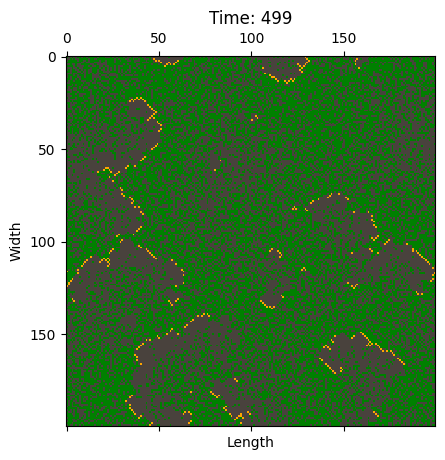

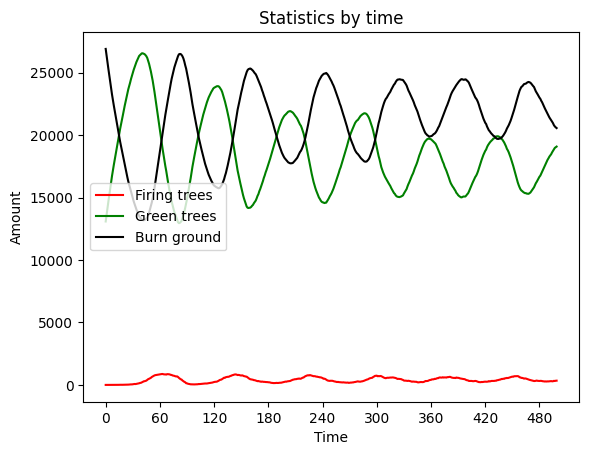

CPU times: total: 3min 21s
Wall time: 3min 23s


In [37]:
%%time
eta = 1/3
dynamic_simulation(num=500, n_type='+')

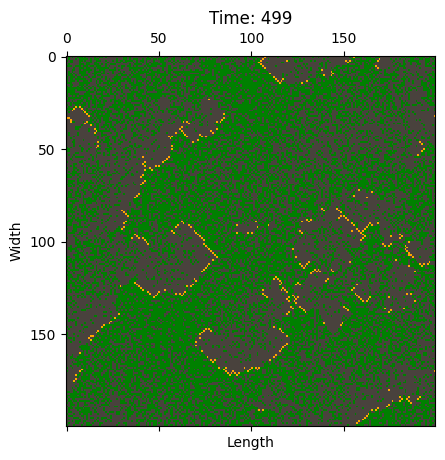

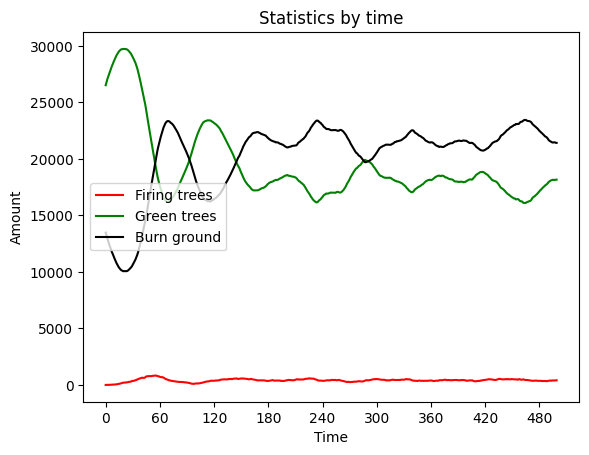

CPU times: total: 3min 20s
Wall time: 3min 21s


In [38]:
%%time
eta = 2/3
dynamic_simulation(num=500, n_type='+')

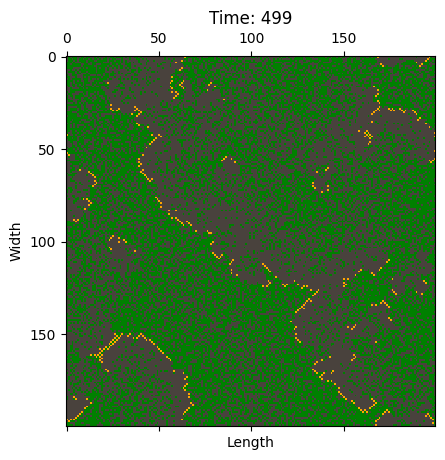

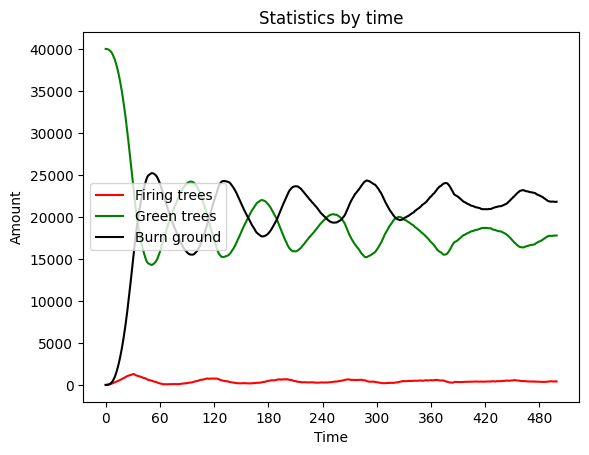

CPU times: total: 3min 19s
Wall time: 3min 20s


In [39]:
%%time
eta = 1
dynamic_simulation(num=500, n_type='+')

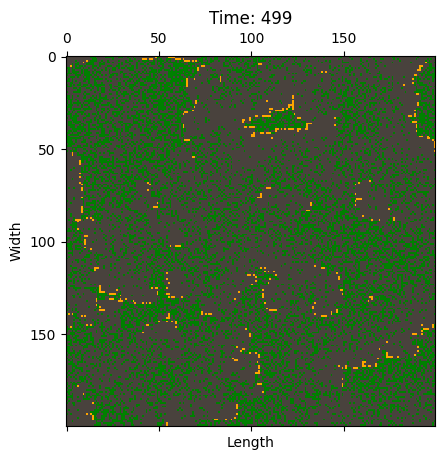

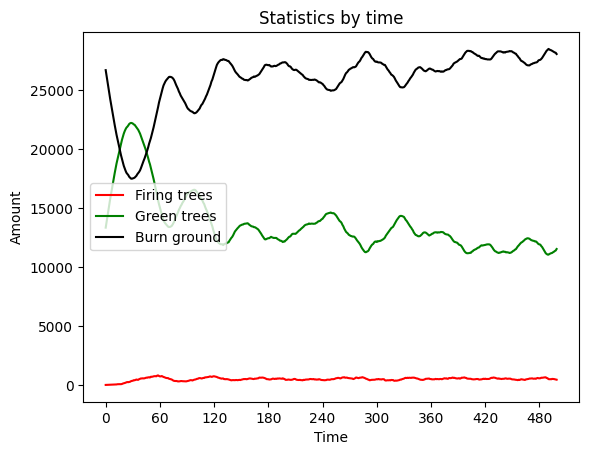

CPU times: total: 4min 9s
Wall time: 4min 11s


In [41]:
%%time
eta = 1/3
dynamic_simulation(num=500, n_type='x')

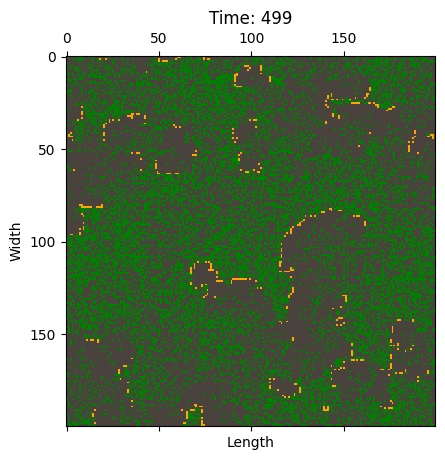

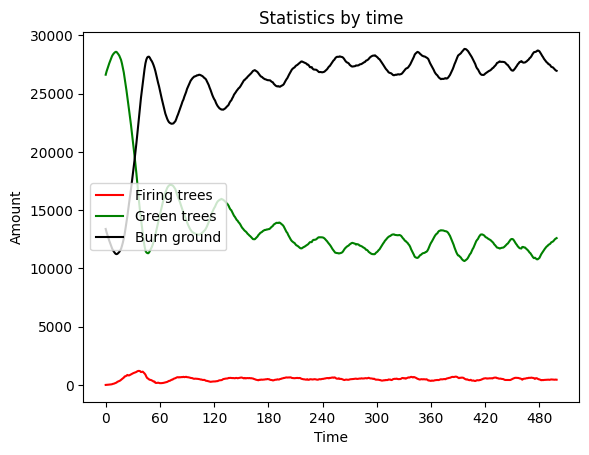

CPU times: total: 4min 10s
Wall time: 4min 11s


In [42]:
%%time
eta = 2/3
dynamic_simulation(num=500, n_type='x')

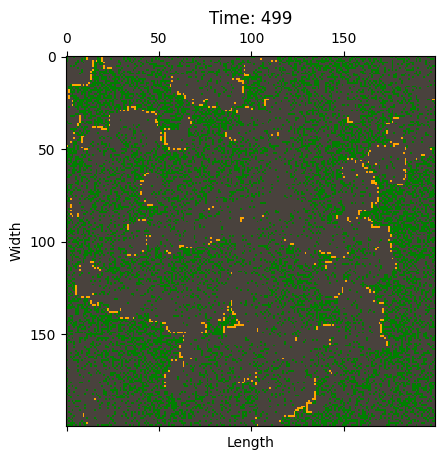

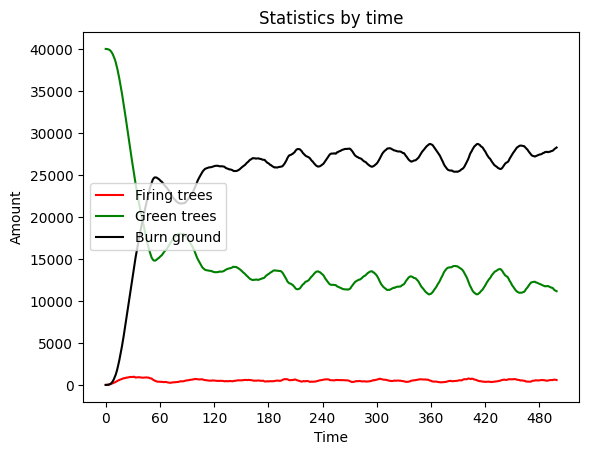

CPU times: total: 4min 9s
Wall time: 4min 11s


In [43]:
%%time
eta = 1
dynamic_simulation(num=500, n_type='x')

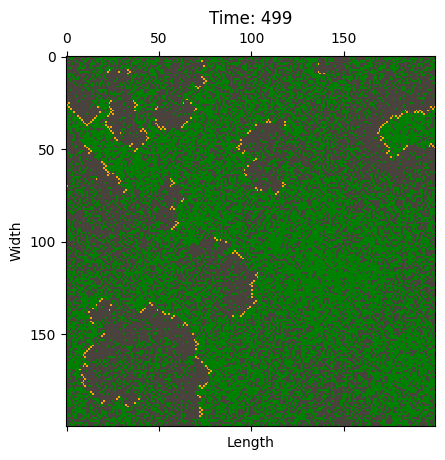

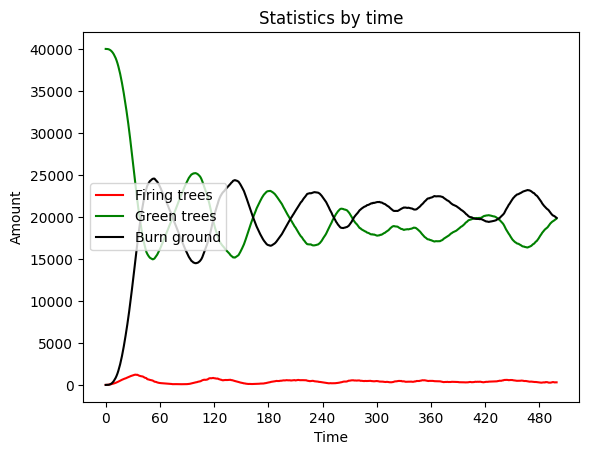

         408453941 function calls (406110927 primitive calls) in 290.020 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 20000000   74.411    0.000  109.527    0.000 2448199855.py:1(update_cell)
 20000000   59.793    0.000   96.985    0.000 4251414467.py:1(get_cross_neighborhood)
 40208566   37.965    0.000   37.965    0.000 {built-in method numpy.array}
110118435   21.097    0.000   28.542    0.000 enum.py:198(__get__)
      500   14.165    0.028  220.778    0.442 1876643335.py:1(update)
 20001002   12.016    0.000   12.016    0.000 {built-in method builtins.sum}
110094363    7.440    0.000    7.440    0.000 enum.py:1322(value)
      501    4.533    0.009    4.533    0.009 {method 'encode' of 'ImagingEncoder' objects}
  1297397    1.839    0.000    1.839    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    93752    1.804    0.000   12.221    0.000 text.py:358(_get_layout)
    58062    1.368    0.000    2.500    0.000 t

In [40]:
cProfile.run('dynamic_simulation(num=500, n_type=\'+\')', sort = 'time')



# TESTS



In [16]:
NeighborhoodType.CROSS.value == '+'

True

In [17]:
CellColor.FIRING.value

'orange'

In [18]:
matrix = np.zeros((2, 3))
type(matrix)
matrix.shape


(2, 3)

In [19]:
cmap_forest.__dict__

{'monochrome': False,
 'colors': ['#49423D', 'orange', 'green'],
 'name': 'from_list',
 'N': 3,
 '_rgba_bad': (0.0, 0.0, 0.0, 0.0),
 '_rgba_under': None,
 '_rgba_over': None,
 '_i_under': 3,
 '_i_over': 4,
 '_i_bad': 5,
 '_isinit': True,
 'colorbar_extend': False,
 '_lut': array([[0.28627451, 0.25882353, 0.23921569, 1.        ],
        [1.        , 0.64705882, 0.        , 1.        ],
        [0.        , 0.50196078, 0.        , 1.        ],
        [0.28627451, 0.25882353, 0.23921569, 1.        ],
        [0.        , 0.50196078, 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        ]])}

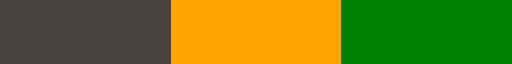

In [20]:
cmap_forest

In [21]:
np.random.random((2, 3)) + 1e-10

array([[0.31479154, 0.69970602, 0.38741896],
       [0.82089415, 0.53756962, 0.58233076]])

In [22]:
zeros = create_ca(5, 7)
trees = grow_trees(zeros, 0.5)
print(trees)
print()
firing = firing_trees(trees, 2)
print(firing)

[[0. 2. 0. 0. 2. 2. 0.]
 [2. 2. 0. 0. 2. 0. 2.]
 [0. 0. 2. 2. 0. 0. 0.]
 [2. 2. 0. 0. 2. 2. 2.]
 [2. 2. 0. 0. 0. 2. 2.]]

[[0. 2. 0. 0. 2. 2. 0.]
 [2. 2. 1. 0. 2. 0. 2.]
 [0. 0. 2. 2. 0. 0. 0.]
 [2. 2. 0. 0. 2. 1. 2.]
 [2. 2. 0. 0. 0. 2. 2.]]


In [23]:
cell = (1, 2)
cell_array = np.array([cell for _ in range(4)])
cell_array

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [24]:
matrix

array([[0., 0., 0.],
       [0., 0., 0.]])

In [25]:
cell = (0, 2)
ca_shape = (5, 7)

print(get_cross_neighborhood(cell, ca_shape))
print(get_neuman_neighborhood(cell, ca_shape))

[array([-1,  2]), array([1, 2]), array([0, 1]), array([0, 3])]
[[-1  2]
 [ 1  2]
 [ 0  1]
 [ 0  3]
 [-1  1]
 [ 1  3]
 [ 1  1]
 [-1  3]]


In [26]:
np.random.rand()

0.1733643950028967

In [27]:
cell = (3, 6)
ca_shape = (5, 7)
i, j = cell

get_cross_neighborhood(cell, ca_shape)

[array([2, 6]), array([4, 6]), array([3, 5]), array([3, 7])]

In [28]:
matrix = np.eye(3, dtype=int)
print(matrix)
print(matrix[1, 1])
values, counts = np.unique(matrix, return_counts=True)
counts[values == 0]

[[1 0 0]
 [0 1 0]
 [0 0 1]]
1


array([6])